In [1]:
### imports

# external modules
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib
from sklearn.preprocessing import StandardScaler

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

2022-06-28 17:45:21.576806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [2]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = True

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [3]:
### Evaluation Parameters

# Select the bias towards recall against precision, treated as a factor (so < 1 biases towards precision, 1 is equal importance, and > 1 biases towards recall)
wpBiasFactor = 20
fmBiasFactor = 2

In [9]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Select a list of good runs to train on in development training_mode
# Should be validated by eye
trainrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                   "297598":[[-1]],
#                   "297604":[[-1]],   # A decently clean histogram
                   "297620":[[-1]],   # A decently clean histogram
                   "297659":[[-1]],   # An okay histogram
                   "297670":[[-1]],   # A decently clean histogram
#                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
#                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                   "299065":[[-1]],   # A decently clean histogram
                   "299067":[[-1]],   # A decently clean histogram
                   "299096":[[-1]],
                   "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
#                    "299185":[[-1]],   # A decently clean histogram
#                    "299327":[[-1]],
#                    "299329":[[-1]], 
#                    "299480":[[-1]]    # A decently clean histogram
                    },
                   '2017C': {
                      "299370":[[-1]],
                      "299394":[[-1]],
                      "299420":[[-1]],
                      "299477":[[-1]],
                      "299593":[[-1]],
                      "299597":[[-1]],
                      "299617":[[-1]],
                      "300018":[[-1]],
                      "300105":[[-1]],
                      "300117":[[-1]],
                      "300124":[[-1]],
                      "300234":[[-1]],
                      "300237":[[-1]],
                      "300240":[[-1]],
                      "300370":[[-1]],
                      "300157":[[-1]],
                      "300373":[[-1]],
                      "300392":[[-1]],
                      "300395":[[-1]],
                      "300401":[[-1]],
                      "300462":[[-1]],
                      "300466":[[-1]],
                      "300514":[[-1]],
                      "300517":[[-1]],
                      "300538":[[-1]],
                      "300539":[[-1]],
                 },'2017F':{
#                      "305310":[[-1]],
#                      "305040":[[-1]],
#                      "305043":[[-1]],
#                      "305185":[[-1]],
#                      "305204":[[-1]],
                      "305234":[[-1]],
                      "305247":[[-1]],
                      "305313":[[-1]],
                      "305338":[[-1]],
                      "305350":[[-1]],
                      "305364":[[-1]],
                      "305376":[[-1]],
                      "306042":[[-1]],
                      "306051":[[-1]],
                      "305406":[[-1]],
                      "306122":[[-1]],
                      "306134":[[-1]],
                      "306137":[[-1]],
                      "306154":[[-1]],
                      "306170":[[-1]],
                      "306417":[[-1]],
                      "306432":[[-1]],
                      "306456":[[-1]],
                      "305516":[[-1]],
                      "305586":[[-1]],
                      "305588":[[-1]],
                      "305590":[[-1]],
                      "305809":[[-1]],
                      "305832":[[-1]],
                      "305840":[[-1]],
                      "305898":[[-1]],
                      "306029":[[-1]],
                      "306037":[[-1]],
                      "306095":[[-1]],
                },
                '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}

# Select a list of good runs to test on in development training_mode
# Should be validated by eye
goodrunsls = {'2017B':{
#                    "297057":[[-1]], 
#                    "297099":[[-1]], 
#                    "297101":[[-1]],
#                    "297113":[[-1]], 
#                    "297114":[[-1]], 
                    "297175":[[-1]],   # A decently clean histogram
#                    "297177":[[-1]],
#                    "297179":[[-1]], 
#                    "297215":[[-1]],
#                    "297218":[[-1]],
#                    "297225":[[-1]],
#                    "297296":[[-1]], 
#                    "297411":[[-1]],
#                    "297426":[[-1]],  
#                    "297431":[[-1]],
#                    "297434":[[-1]], 
#                    "297468":[[-1]],
#                    "297483":[[-1]],
#                    "297486":[[-1]],
#                    "297503":[[-1]],
#                    "297557":[[-1]],
#                    "297598":[[-1]],
#                    "297604":[[-1]],   # A decently clean histogram
#                    "297620":[[-1]],   # A decently clean histogram
                    "297659":[[-1]],   # An okay histogram
                    "297670":[[-1]],   # A decently clean histogram
                    "297674":[[-1]],
#                    "297678":[[-1]],   # A particularly messy histogram
                    "297722":[[-1]],   # A decently clean histogram
#                    "298997":[[-1]],
#                    "299061":[[-1]],
                    "299065":[[-1]],   # A decently clean histogram
                    "299067":[[-1]],   # A decently clean histogram
#                    "299096":[[-1]],
#                    "299149":[[-1]],
#                    "299178":[[-1]],   # A decently clean histogram
#                    "299184":[[-1]],   # A particularly messy histogram
                    "299185":[[-1]],   # A decently clean histogram
                    "299327":[[-1]],
#                    "299329":[[-1]], 
                    "299480":[[-1]]    # A decently clean histogram
                    },
                '2017C':{
#                      "299370":[[-1]],
#                      "299394":[[-1]],
#                      "299420":[[-1]],
#                      "299477":[[-1]],
#                      "299593":[[-1]],
#                      "299597":[[-1]],
#                      "299617":[[-1]],
#                      "300018":[[-1]],
#                      "300105":[[-1]],
#                      "300117":[[-1]],
#                      "300124":[[-1]],
#                      "300234":[[-1]],
#                      "300237":[[-1]],
#                      "300240":[[-1]],
#                      "300370":[[-1]],
#                      "300157":[[-1]],
#                      "300373":[[-1]],
#                      "300392":[[-1]],
#                      "300395":[[-1]],
#                      "300401":[[-1]],
#                      "300462":[[-1]],
#                      "300466":[[-1]],
                      "300514":[[-1]],
                      "300517":[[-1]],
                      "300538":[[-1]],
                      "300539":[[-1]],
                },'2017F':{
                      "305310":[[-1]],
                      "305040":[[-1]],
                      "305043":[[-1]],
                      "305185":[[-1]],
                      "305204":[[-1]],
#                      "305234":[[-1]],
#                      "305247":[[-1]],
#                      "305313":[[-1]],
#                      "305338":[[-1]],
#                      "305350":[[-1]],
#                      "305364":[[-1]],
#                      "305376":[[-1]],
#                      "306042":[[-1]],
#                      "306051":[[-1]],
#                      "305406":[[-1]],
#                      "306122":[[-1]],
#                      "306134":[[-1]],
#                      "306137":[[-1]],
#                      "306154":[[-1]],
#                      "306170":[[-1]],
#                      "306417":[[-1]],
#                      "306432":[[-1]],
#                      "306456":[[-1]],
#                      "305516":[[-1]],
#                      "305586":[[-1]],
#                      "305588":[[-1]],
#                      "305590":[[-1]],
#                      "305809":[[-1]],
#                      "305832":[[-1]],
#                      "305840":[[-1]],
#                      "305898":[[-1]],
#                      "306029":[[-1]],
#                      "306037":[[-1]],
#                      "306095":[[-1]],
                },
                '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}


badrunsls = {'2017B':
                {
                    #"297048":[[-1]],
                    #"297282":[[-1]],
                    #"297283":[[-1]],
                    #"297284":[[-1]],
                    #"297287":[[-1]],
                    #"297288":[[-1]],
                    #"297289":[[-1]],
                    "299316":[[-1]],
                    "299317":[[-1]],
                    "299318":[[-1]],
                    "299324":[[-1]],
                    "299326":[[-1]],
                    #"301086":[[88,126]],
                    #"301086":[[89,89]],
                    #"303948":[[1710,1710]],
                    "297047":[[-1]], #close but, true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297211":[[-1]], #Reconstructs well
#                   "299325":[[-1]], #Reconstructs well
                    "297664":[[-1]], #true bad for all 8
                    "299317":[[-1]], #true bad for all 8
                    "297169":[[-1]], #true bad for all 8
#                   "297502":[[-1]]
                },
             '2017C':{
                "300079":[[-1]],
                "300282":[[-1]],
                "300389":[[-1]],
                "300398":[[-1]],
                 
                 
#                 "300781":[[-1]], # bad for tracking (pixels were excluded.
#                 "300079":[[-1]], # is bad for strips and then also for tracking
#                 "302029":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good 
#                 "300576":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "300574":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "300282":[[-1]], # Poor detector elements for strips - Should be mildly anomalous, but technically good
#                 "301912":[[-1]], # Half bad for pixels (lost HV or readout card)  
#                 "301086":[[-1]], # Half bad for pixels (lost HV or readout card)  
#                 "300283":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300282":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300281":[[-1]], # Half bad for pixels (lost HV or readout card) 
#                 "300239":[[-1]], # Half bad for pixels (lost HV or readout card)
#                 "301394":[[-1]], # Marginal for pixels
#                 "301183":[[-1]], # Marginal for pixels
#                 "300398":[[-1]], # Marginal for pixels
#                 "300389":[[-1]], # Marginal for pixels
#                 "300365":[[-1]]  # Marginal for pixels
              },
             '2017E':{
                 "304740":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304776":[[-1]], # Bad for pixels and tracking - holes in PXLayer 1
                 "304506":[[-1]], # Portcard problem for pixels
                 "304507":[[-1]], # Portcard problem for pixels 
                 "303989":[[-1]], # Bad for pixels, power supply died
                 "303824":[[-1]]  # Partly bad for strips due to a test
             },
             '2017F':{
                 "306422":[[-1]], # Partly bad for strips - 2 data readouts failed 
#                 "306423":[[-1]], # Partly bad for strips - 2 data readouts failed
#                 "306425":[[-1]], # Partly bad for strips - 2 data readouts failed
#                 "305440":[[-1]], # Partly bad for strips - 1 data readout failed
#                 "305441":[[-1]], # Partly bad for strips - 1 data readout failed
                 "305249":[[-1]], # Bad for pixels - half of disk failed 
                 "305250":[[-1]], # Bad for pixels - half of disk failed
#                 "305064":[[-1]], # Marginal for pixels - some readout failed
             },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}


# The year and era being used
year = '2017'
era = 'F'

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1', 'chargeOuter_PXLayer_1', 'adc_PXLayer_1', 'size_PXLayer_1'],
    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2', 'adc_PXLayer_2', 'size_PXLayer_2'],
    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3', 'adc_PXLayer_3', 'size_PXLayer_3'],
    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4', 'adc_PXLayer_4', 'size_PXLayer_4'],
    ['charge_PXDisk_+1', 'adc_PXDisk_+1'],
    ['charge_PXDisk_-1', 'adc_PXDisk_-1'],
    ['charge_PXDisk_+2', 'adc_PXDisk_+2'],
    ['charge_PXDisk_-2', 'adc_PXDisk_-2'],
    ['charge_PXDisk_+3', 'adc_PXDisk_+3'],
    ['charge_PXDisk_-3', 'adc_PXDisk_-3'],
    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [10]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

# Selects whether to create a new histstruct or use a saved one
readnew = True

# Select whether to save a new histstruct
save = False

In [11]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

# Evaluate models seperately, as an ensemble, both, or neither
individualEval = True
ensembleEval = False

In [12]:
### Define Training Mode Parameters - Combined Autoencoder
if training_mode == 'global':
    runsls_training = None # use none to not add a mask for training (can e.g. use DCS-bit on mask)
    runsls_good = None # use none to not add a mask for good runs (can e.g. use averages of training set)
    runsls_bad = badrunsls[year] # predefined bad runs
    print('selected runs/lumisections for training: all')
    
elif training_mode == 'local':
    # train locally on a small set of runs
    # - either on n runs preceding a chosen application run,
    # - or on the run associated as reference to the chosen application run.
    # - this only works for a single era
    
    available_runs = dfu.get_runs( dfu.select_dcson( csvu.read_csv('../data/DF'+year+era+'_'+histnames[0][0]+'.csv') ) )
    # Cherry picked really bad run
    run_application = 299316
    #run_application = 299317
    run_application_index = available_runs.index(run_application)
    # select training set
    usereference = False
    if usereference:
        run_reference = rru.get_reference_run( run_application, jsonfile='../utils/json_allRunsRefRuns.json' )
        if run_reference<0:
            raise Exception('no valid reference run has been defined for run {}'.format(run_application))
        runsls_training = jsonu.tuplelist_to_jsondict([(run_reference,[-1])])
    else:
        ntraining = 5
        offset = 0 # normal case: offset = 0 (just use 5 previous runs)
        
        # Selects the 5 previous runs for training
        runsls_training = jsonu.tuplelist_to_jsondict([(el,[-1]) for el in available_runs[run_application_index-ntraining-offset:run_application_index-offset]])
    #runsls_bad = badrunsls[year]
    #runsls_good = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_bad = jsonu.tuplelist_to_jsondict([(run_application,[-1])])
    runsls_good = runsls_training
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)
        
elif training_mode == 'development':
    # train on a user-defined subset of runs
    
    # Select runs to be used in training from the user-defined list
    runsls_training = trainrunsls[year + era]
    # Select bad runs to test on in the user-defined list
    runsls_bad = badrunsls[year + era]
    # Select good runs to test on in the user-defined list
    runsls_good = goodrunsls[year + era]
    
    print('selected runs/lumisections for training: ')
    print(runsls_training)
    print('selected runs/lumisections as good test set:')
    print(runsls_good)
    print('selected runs/lumisections as bad test set:')
    print(runsls_bad)

selected runs/lumisections for training: 
{'305234': [[-1]], '305247': [[-1]], '305313': [[-1]], '305338': [[-1]], '305350': [[-1]], '305364': [[-1]], '305376': [[-1]], '306042': [[-1]], '306051': [[-1]], '305406': [[-1]], '306122': [[-1]], '306134': [[-1]], '306137': [[-1]], '306154': [[-1]], '306170': [[-1]], '306417': [[-1]], '306432': [[-1]], '306456': [[-1]], '305516': [[-1]], '305586': [[-1]], '305588': [[-1]], '305590': [[-1]], '305809': [[-1]], '305832': [[-1]], '305840': [[-1]], '305898': [[-1]], '306029': [[-1]], '306037': [[-1]], '306095': [[-1]]}
selected runs/lumisections as good test set:
{'305310': [[-1]], '305040': [[-1]], '305043': [[-1]], '305185': [[-1]], '305204': [[-1]]}
selected runs/lumisections as bad test set:
{'306422': [[-1]], '305249': [[-1]], '305250': [[-1]]}


In [ ]:
### Data Import

# Create a new HistStruct from the data
if readnew:
    # Initializations
    dloader = DataLoader.DataLoader()
    histstruct = SubHistStruct.SubHistStruct()
    histstruct.reset_histlist(histnames)
    
    # Unpack histnames and add every histogram individually
    for histnamegroup in histnames:
        for histname in histnamegroup:
            print('Adding {}...'.format(histname))
            
            # Bring the histograms into memory from storage for later use
            filename = datadir + year + era + '/DF' + year + era + '_' + histname + '.csv'
            df = dloader.get_dataframe_from_file( filename )
            
            # In case of local training, we can remove most of the histograms
            if( runsls_training is not None and runsls_good is not None and runsls_bad is not None ):
                runsls_total = {k: v for d in (runsls_training, runsls_good, runsls_bad) for k, v in d.items()}
                df = dfu.select_runsls( df, runsls_total )    
                
            # Store the data in the histstruct object managing this whole thing
            histstruct.add_dataframe( df, rebinningfactor = 1, standardbincount = 102 )
        
    print('Found {} histograms'.format(len(histstruct.runnbs)))

# Load a previously saved HistStruct
else:
    # Load histstruct from storage
    histstruct = HistStruct.HistStruct.load('test.pk1')
    
    # Count of bad runs, presumably for later use
    nbadruns = len([name for name in list(histstruct.masks.keys()) if 'bad' in name])
    
if userfriendly:
    print('Created a histstruct with the following properties:')
    print('- number of histogram types: {}'.format(len(histstruct.histnames)))
    print('- number of lumisections: {}'.format(len(histstruct.lsnbs)))

Adding NormalizedHitResiduals_TIB__Layer__1...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__1...
Adding NormalizedHitResiduals_TIB__Layer__2...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__2...
Adding NormalizedHitResiduals_TIB__Layer__3...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__3...
Adding NormalizedHitResiduals_TIB__Layer__4...
Adding Summary_ClusterStoNCorr__OnTrack__TIB__layer__4...
Adding chargeInner_PXLayer_1...
Adding chargeOuter_PXLayer_1...
Adding adc_PXLayer_1...
Adding size_PXLayer_1...
Adding chargeInner_PXLayer_2...
Adding chargeOuter_PXLayer_2...
Adding adc_PXLayer_2...
Adding size_PXLayer_2...
Adding chargeInner_PXLayer_3...
Adding chargeOuter_PXLayer_3...
Adding adc_PXLayer_3...
Adding size_PXLayer_3...
Adding chargeInner_PXLayer_4...
Adding chargeOuter_PXLayer_4...
Adding adc_PXLayer_4...
Adding size_PXLayer_4...
Adding charge_PXDisk_+1...
Adding adc_PXDisk_+1...
Adding charge_PXDisk_-1...
Adding adc_PXDisk_-1...
Adding charge_PXDisk_+2...

In [ ]:
### Add Masks to Data

if readnew:
    histstruct.add_dcsonjson_mask( 'dcson' )
    histstruct.add_goldenjson_mask('golden' )
    histstruct.add_highstat_mask( 'highstat' )
    histstruct.add_stat_mask( 'lowstat', max_entries_to_bins_ratio=100 )
    if runsls_training is not None: histstruct.add_json_mask( 'training', runsls_training )
    if runsls_good is not None: histstruct.add_json_mask( 'good', runsls_good )
        
    # Distinguishing bad runs
    nbadruns = 0
    if runsls_bad is not None:
        print(runsls_bad)
        histstruct.add_json_mask( 'bad', runsls_bad )
        
        # Special case for bad runs: add a mask per run (different bad runs have different characteristics)
        nbadruns = len(runsls_bad.keys())
        for i,badrun in enumerate(runsls_bad.keys()):
            histstruct.add_json_mask( 'bad{}'.format(i), {badrun:runsls_bad[badrun]} )
            
    if save:
        histstruct.save('test.pk1')
if userfriendly: print('Assigned masks: {}'.format(list(histstruct.masks.keys())))

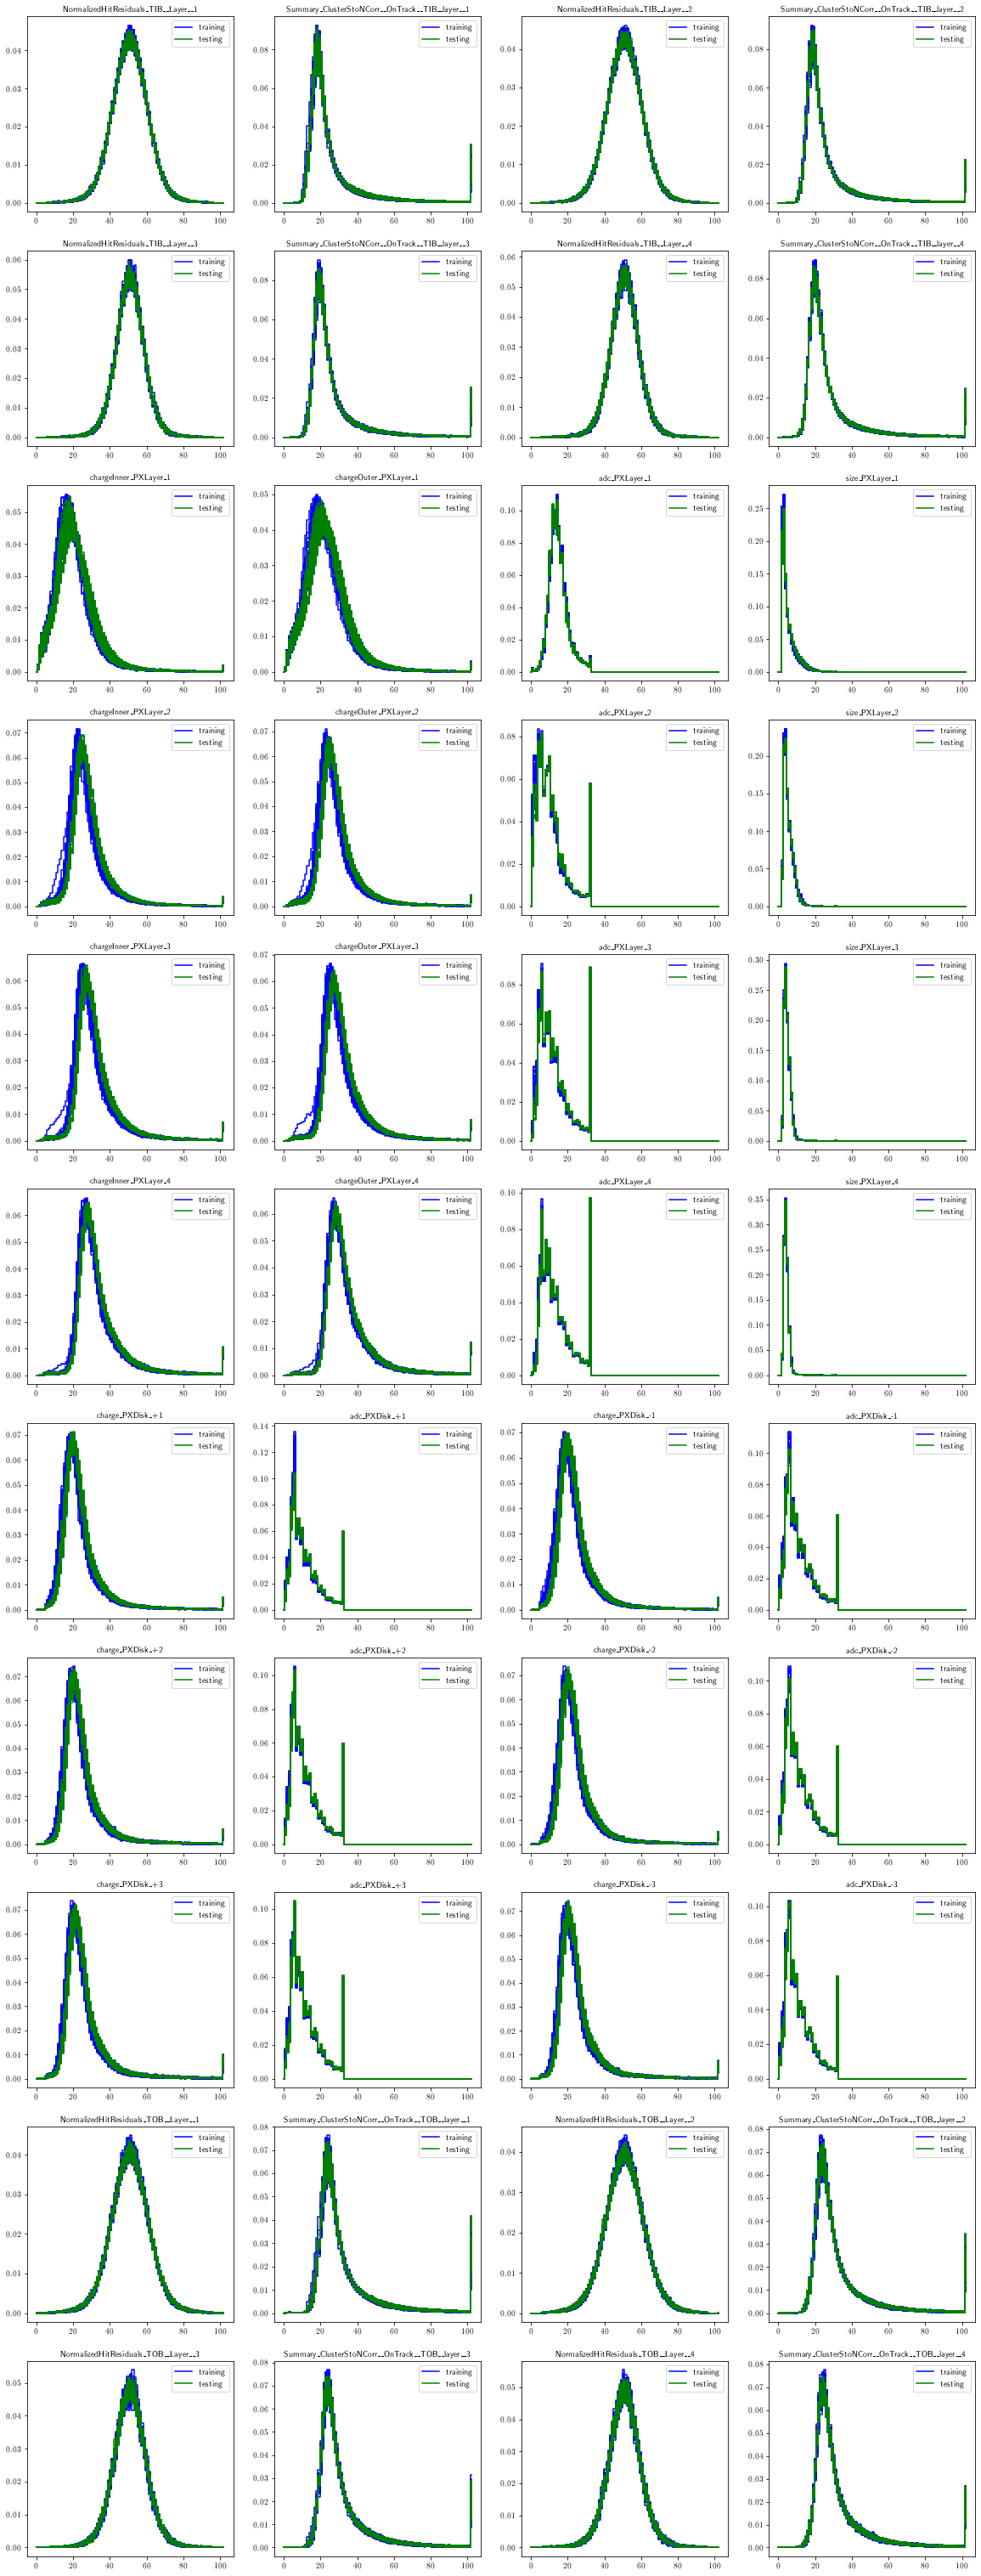

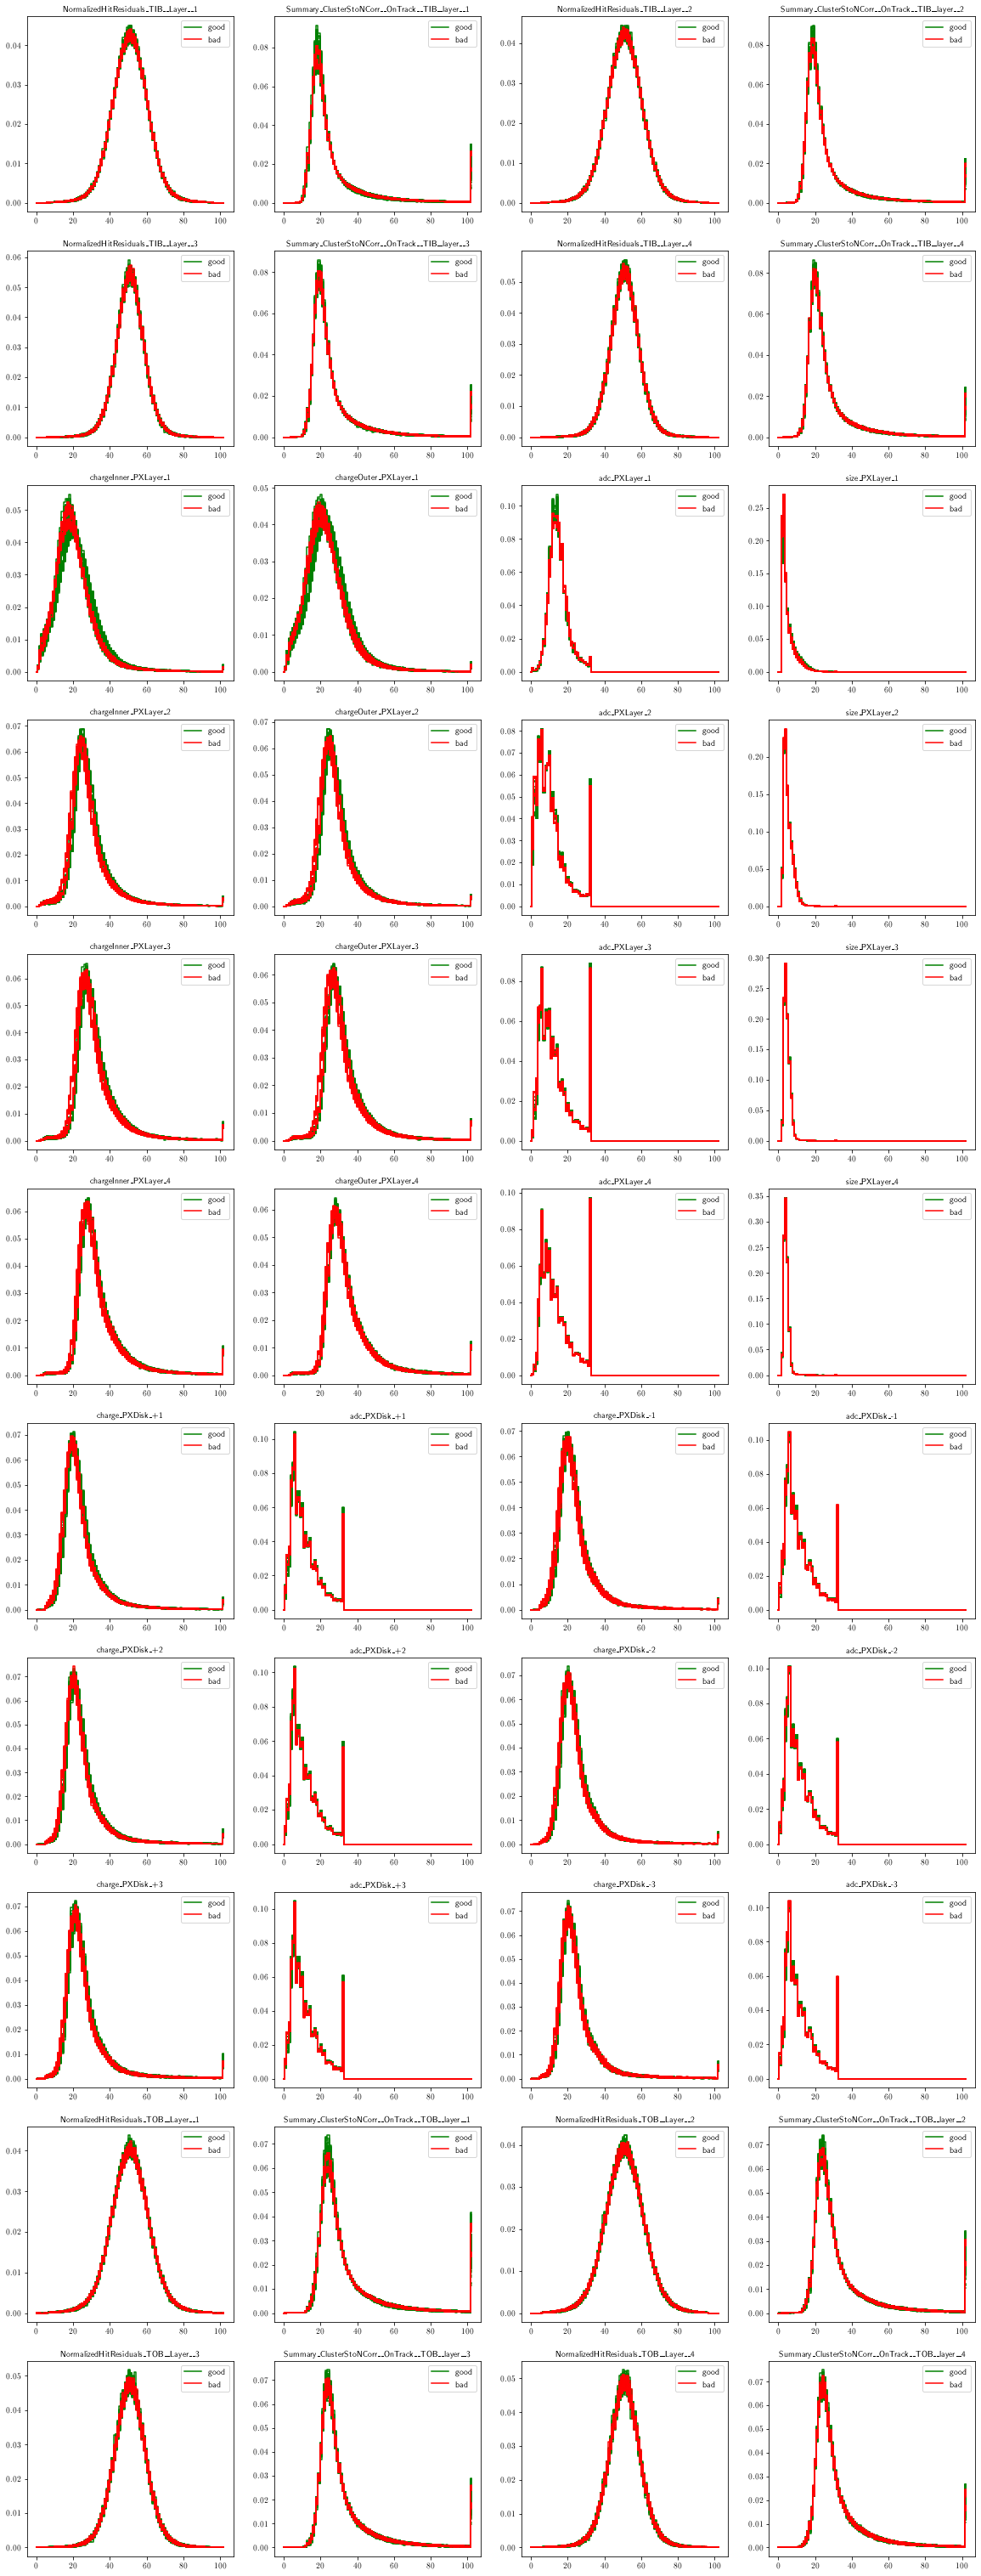

In [44]:
### Plotting the input data for analysis

if((training_mode=='local' or training_mode == 'development') and createPlots):

    # training and application runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','training'],['dcson','highstat','good']],
                                labellist = ['training','testing'],
                                colorlist = ['blue','green']
                              )
    
    # application run and bad test runs
    histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad']],
                                labellist = ['good','bad'],
                                colorlist = ['green','red']
                              )
    
elif( training_mode=='global' and createPlots):
    
    # bad test runs
    for i in [0,1,2,3,4,5,6]:
        histstruct.plot_histograms( masknames=[['dcson','highstat','good'],['dcson','highstat','bad{}'.format(i)]],
                                labellist = ['typical good histograms','bad'],
                                colorlist = ['blue','red'],
                                transparencylist = [0.01,1.]
                                    )

In [10]:
def define_concatamash_autoencoder(histstruct):
    
    histslist = []
    vallist = []
    autoencoders = []
    if trainnew:
        for i,histnamegroup in enumerate(histnames):
            
            train_normhist = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'training']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
            X_train, X_val = train_test_split(train_normhist, test_size=0.4, random_state=42)
            
            if userfriendly:
                print('\nNow Defining model {}/'.format(i + 1) 
                      + str(len(histnames)))
                print(' - Size of training set: {}'.format(X_train.shape))
            
            # Half the total bin count
            arch = 51 * len(histnamegroup)
            
            ## Model parameters
            print(X_train.shape)
            
            input_dim = X_train.shape[2] #num of predictor variables
            Input_layers=[Input(shape=input_dim) for i in range((X_train.shape[1]))]
            
            # Defining layers
            conc_layer = Concatenate()(Input_layers)
            encoder = Dense(arch * 2, activation="tanh")(conc_layer)
            #encoder = Dense(128, activation='relu')(encoder)
            #
            #encoder = Dense(32, activation='relu')(encoder)
            
            decoder = Dense(arch, activation="relu")(encoder)
            #decoder = Dense(256, activation="tanh")(decoder)
            
            Output_layers=[Dense(input_dim, activation="tanh")(decoder) for i in range(X_train.shape[1])]

            autoencoder = Model(inputs=Input_layers, outputs=Output_layers)
            autoencoder.summary()
            autoencoders.append(autoencoder)
            
            histslist.append(X_train)
            vallist.append(X_val)
     
    # Return the histograms stored 2-Dimensionally and the autoencoders corresponding
    return(histslist, vallist, autoencoders, train_normhist)

In [11]:
(histslist, vallist, autoencoders, train_normhist) = define_concatamash_autoencoder(histstruct)


Now Defining model 1/12
 - Size of training set: (6503, 8, 102)
(6503, 8, 102)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 102)]        0                                            
______________

2022-06-27 15:11:41.254821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.cern.ch/lc


Now Defining model 2/12
 - Size of training set: (6503, 4, 102)
(6503, 4, 102)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 102)]        0                                            
____________


Now Defining model 6/12
 - Size of training set: (6503, 2, 102)
(6503, 2, 102)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 204)          0           input_25[0][0]                   
                                                                 input_26[0][0]                   
__________________________________________________________________________________________________
dense_34 (De


Now Defining model 12/12
 - Size of training set: (6503, 8, 102)
(6503, 8, 102)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           [(None, 102)]        0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 102)]        0                                            
__________

In [12]:
### Trains a combined autoencoder for every merge set
def train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders):
    
    # Iterate through the training data to train corresponding autoencoders
    for i in range(len(histslist)):
        
        if userfriendly: print('\nNow training model {}/'.format(i + 1) + str(len(histslist)))
        
        # Set variables to temporary values for better transparency
        X_train = histslist[i]
        X_val = vallist[i]
        autoencoder = autoencoders[i]
        
        
        ## Model parameters
        nb_epoch = 500
        batch_size = 50
        
        #checkpoint_filepath = 'checkpoint'
        #model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #   filepath=checkpoint_filepath,
        #   save_weights_only=False,
        #   verbose=1,
        #   save_best_only=True,
        #   monitor='val_loss',
        #   mode='min')
        
        # Tell the model when to stop
        earlystop = EarlyStopping(monitor='val_loss',
            min_delta=1e-7,
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None,
            restore_best_weights=True,
        )
        lr =0.001
        opt = keras.optimizers.Adam(learning_rate=lr)
        
        autoencoder.compile(loss='mse',
                            optimizer=opt)
        
        ## Train autoencoder
        train = autoencoder.fit(x=[X_train[:,i] for i in range(X_train.shape[1])],
                                y=[X_train[:,i] for i in range(X_train.shape[1])],
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=([X_val[:,i] for i in range(X_val.shape[1])], [X_val[:,i] for i in range(X_val.shape[1])]),
                            verbose=1,
                            callbacks= [earlystop],    
                            )
        
        # Create a plot of the model
        
        tf.keras.utils.plot_model(
            autoencoder,
            to_file="models/modelConcatamash{}.png".format(i),
            show_shapes=True,
            show_dtype=False,
            show_layer_names=False,
            rankdir="TB")
        
        # Save classifier for evaluation
        classifier = AutoEncoder.AutoEncoder(model=autoencoder)
        histstruct.add_classifier(histnames[i][0], classifier)        

In [13]:
start = time.perf_counter()
train_concatamash_autoencoder(histstruct, histslist, vallist, autoencoders)
stop = time.perf_counter()
print(stop - start)


Now training model 1/12


2022-06-27 15:11:42.951314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-27 15:11:42.953886: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/500
131/131 [==============================] - 4s 17ms/step - loss: 1.8993e-04 - dense_2_loss: 1.8341e-05 - dense_3_loss: 2.9632e-05 - dense_4_loss: 1.7344e-05 - dense_5_loss: 2.6126e-05 - dense_6_loss: 2.3221e-05 - dense_7_loss: 2.6719e-05 - dense_8_loss: 2.2507e-05 - dense_9_loss: 2.6036e-05 - val_loss: 4.7834e-06 - val_dense_2_loss: 3.6184e-07 - val_dense_3_loss: 1.2049e-06 - val_dense_4_loss: 3.0146e-07 - val_dense_5_loss: 7.2912e-07 - val_dense_6_loss: 4.0376e-07 - val_dense_7_loss: 7.8769e-07 - val_dense_8_loss: 4.2518e-07 - val_dense_9_loss: 5.6941e-07
Epoch 2/500
131/131 [==============================] - 2s 13ms/step - loss: 6.2974e-06 - dense_2_loss: 5.3120e-07 - dense_3_loss: 1.3985e-06 - dense_4_loss: 5.1737e-07 - dense_5_loss: 9.0583e-07 - dense_6_loss: 6.2054e-07 - dense_7_loss: 9.0219e-07 - dense_8_loss: 6.3920e-07 - dense_9_loss: 7.8260e-07 - val_loss: 5.1802e-06 - val_dense_2_loss: 3.6492e-07 - val_dense_3_loss: 1.1985e-06 - val_dense_4_loss: 4.3923e-07 - val_d

131/131 [==============================] - 2s 13ms/step - loss: 1.3321e-06 - dense_2_loss: 1.4236e-07 - dense_3_loss: 1.4384e-07 - dense_4_loss: 1.4944e-07 - dense_5_loss: 1.3617e-07 - dense_6_loss: 2.1102e-07 - dense_7_loss: 1.6428e-07 - dense_8_loss: 2.1820e-07 - dense_9_loss: 1.6677e-07 - val_loss: 1.2435e-06 - val_dense_2_loss: 1.3369e-07 - val_dense_3_loss: 1.2628e-07 - val_dense_4_loss: 1.4447e-07 - val_dense_5_loss: 1.4306e-07 - val_dense_6_loss: 1.9614e-07 - val_dense_7_loss: 1.3092e-07 - val_dense_8_loss: 2.1925e-07 - val_dense_9_loss: 1.4968e-07
Epoch 30/500
131/131 [==============================] - 2s 12ms/step - loss: 1.3004e-06 - dense_2_loss: 1.3920e-07 - dense_3_loss: 1.4016e-07 - dense_4_loss: 1.4612e-07 - dense_5_loss: 1.3572e-07 - dense_6_loss: 2.0329e-07 - dense_7_loss: 1.6039e-07 - dense_8_loss: 2.1220e-07 - dense_9_loss: 1.6328e-07 - val_loss: 1.1402e-06 - val_dense_2_loss: 1.1402e-07 - val_dense_3_loss: 1.2191e-07 - val_dense_4_loss: 1.2207e-07 - val_dense_5_loss

131/131 [==============================] - 2s 13ms/step - loss: 4.6881e-06 - dense_2_loss: 7.2452e-08 - dense_3_loss: 1.7742e-06 - dense_4_loss: 6.8699e-08 - dense_5_loss: 9.3204e-07 - dense_6_loss: 1.3164e-07 - dense_7_loss: 8.7648e-07 - dense_8_loss: 1.4948e-07 - dense_9_loss: 6.8304e-07 - val_loss: 4.5689e-06 - val_dense_2_loss: 7.0691e-08 - val_dense_3_loss: 1.7260e-06 - val_dense_4_loss: 6.7677e-08 - val_dense_5_loss: 9.0960e-07 - val_dense_6_loss: 1.3052e-07 - val_dense_7_loss: 8.5202e-07 - val_dense_8_loss: 1.4773e-07 - val_dense_9_loss: 6.6465e-07
Epoch 58/500
131/131 [==============================] - 2s 13ms/step - loss: 4.6757e-06 - dense_2_loss: 7.2376e-08 - dense_3_loss: 1.7692e-06 - dense_4_loss: 6.8730e-08 - dense_5_loss: 9.2956e-07 - dense_6_loss: 1.3159e-07 - dense_7_loss: 8.7400e-07 - dense_8_loss: 1.4945e-07 - dense_9_loss: 6.8087e-07 - val_loss: 4.5762e-06 - val_dense_2_loss: 7.0750e-08 - val_dense_3_loss: 1.7281e-06 - val_dense_4_loss: 6.7571e-08 - val_dense_5_loss

Epoch 8/500
131/131 [==============================] - 1s 5ms/step - loss: 2.3039e-06 - dense_12_loss: 5.9551e-07 - dense_13_loss: 5.7342e-07 - dense_14_loss: 4.8836e-07 - dense_15_loss: 6.4656e-07 - val_loss: 2.1039e-06 - val_dense_12_loss: 5.6898e-07 - val_dense_13_loss: 5.6716e-07 - val_dense_14_loss: 4.2135e-07 - val_dense_15_loss: 5.4645e-07
Epoch 9/500
131/131 [==============================] - 1s 5ms/step - loss: 1.8945e-06 - dense_12_loss: 5.1119e-07 - dense_13_loss: 4.9043e-07 - dense_14_loss: 4.0127e-07 - dense_15_loss: 4.9158e-07 - val_loss: 1.6771e-06 - val_dense_12_loss: 4.2557e-07 - val_dense_13_loss: 4.5275e-07 - val_dense_14_loss: 3.7340e-07 - val_dense_15_loss: 4.2538e-07
Epoch 10/500
131/131 [==============================] - 1s 5ms/step - loss: 1.5580e-06 - dense_12_loss: 4.0975e-07 - dense_13_loss: 4.0117e-07 - dense_14_loss: 3.4448e-07 - dense_15_loss: 4.0260e-07 - val_loss: 1.4662e-06 - val_dense_12_loss: 4.0594e-07 - val_dense_13_loss: 3.5531e-07 - val_dense_14_l

131/131 [==============================] - 1s 5ms/step - loss: 4.9110e-07 - dense_12_loss: 1.4483e-07 - dense_13_loss: 1.4405e-07 - dense_14_loss: 7.9788e-08 - dense_15_loss: 1.2243e-07 - val_loss: 5.2461e-07 - val_dense_12_loss: 1.7936e-07 - val_dense_13_loss: 1.5307e-07 - val_dense_14_loss: 7.1250e-08 - val_dense_15_loss: 1.2092e-07
Epoch 55/500
131/131 [==============================] - 1s 5ms/step - loss: 5.0108e-07 - dense_12_loss: 1.4931e-07 - dense_13_loss: 1.4571e-07 - dense_14_loss: 8.1012e-08 - dense_15_loss: 1.2504e-07 - val_loss: 8.3417e-07 - val_dense_12_loss: 2.3951e-07 - val_dense_13_loss: 2.2244e-07 - val_dense_14_loss: 1.4866e-07 - val_dense_15_loss: 2.2355e-07
Epoch 56/500
131/131 [==============================] - 1s 5ms/step - loss: 4.8961e-07 - dense_12_loss: 1.4607e-07 - dense_13_loss: 1.4513e-07 - dense_14_loss: 7.8152e-08 - dense_15_loss: 1.2025e-07 - val_loss: 5.1249e-07 - val_dense_12_loss: 1.6572e-07 - val_dense_13_loss: 1.5654e-07 - val_dense_14_loss: 8.3824

131/131 [==============================] - 1s 5ms/step - loss: 1.2491e-06 - dense_18_loss: 3.3376e-07 - dense_19_loss: 3.0170e-07 - dense_20_loss: 1.9755e-07 - dense_21_loss: 4.1612e-07 - val_loss: 1.3206e-06 - val_dense_18_loss: 3.4043e-07 - val_dense_19_loss: 3.3001e-07 - val_dense_20_loss: 2.0384e-07 - val_dense_21_loss: 4.4630e-07
Epoch 11/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2121e-06 - dense_18_loss: 3.2102e-07 - dense_19_loss: 2.9986e-07 - dense_20_loss: 1.8421e-07 - dense_21_loss: 4.0701e-07 - val_loss: 1.0439e-06 - val_dense_18_loss: 2.8185e-07 - val_dense_19_loss: 2.6803e-07 - val_dense_20_loss: 1.3373e-07 - val_dense_21_loss: 3.6034e-07
Epoch 12/500
131/131 [==============================] - 1s 5ms/step - loss: 1.2306e-06 - dense_18_loss: 3.2298e-07 - dense_19_loss: 3.0008e-07 - dense_20_loss: 1.9833e-07 - dense_21_loss: 4.0918e-07 - val_loss: 1.3211e-06 - val_dense_18_loss: 3.7280e-07 - val_dense_19_loss: 3.2818e-07 - val_dense_20_loss: 1.8083

131/131 [==============================] - 1s 5ms/step - loss: 4.1833e-07 - dense_18_loss: 1.2530e-07 - dense_19_loss: 1.3210e-07 - dense_20_loss: 5.5770e-08 - dense_21_loss: 1.0515e-07 - val_loss: 4.6013e-07 - val_dense_18_loss: 1.4369e-07 - val_dense_19_loss: 1.4911e-07 - val_dense_20_loss: 5.9290e-08 - val_dense_21_loss: 1.0805e-07
Epoch 57/500
131/131 [==============================] - 1s 5ms/step - loss: 4.3267e-07 - dense_18_loss: 1.2771e-07 - dense_19_loss: 1.3457e-07 - dense_20_loss: 6.2750e-08 - dense_21_loss: 1.0764e-07 - val_loss: 4.9068e-07 - val_dense_18_loss: 1.4638e-07 - val_dense_19_loss: 1.5555e-07 - val_dense_20_loss: 7.6953e-08 - val_dense_21_loss: 1.1180e-07
Epoch 58/500
131/131 [==============================] - 1s 6ms/step - loss: 4.1023e-07 - dense_18_loss: 1.2266e-07 - dense_19_loss: 1.2811e-07 - dense_20_loss: 5.2532e-08 - dense_21_loss: 1.0693e-07 - val_loss: 5.8617e-07 - val_dense_18_loss: 1.6056e-07 - val_dense_19_loss: 1.8346e-07 - val_dense_20_loss: 9.3954

131/131 [==============================] - 1s 5ms/step - loss: 1.0358e-06 - dense_24_loss: 2.7992e-07 - dense_25_loss: 2.6931e-07 - dense_26_loss: 1.7801e-07 - dense_27_loss: 3.0856e-07 - val_loss: 1.5109e-06 - val_dense_24_loss: 4.1726e-07 - val_dense_25_loss: 3.5800e-07 - val_dense_26_loss: 2.7468e-07 - val_dense_27_loss: 4.6097e-07
Epoch 18/500
131/131 [==============================] - 1s 5ms/step - loss: 1.0361e-06 - dense_24_loss: 2.7710e-07 - dense_25_loss: 2.7453e-07 - dense_26_loss: 1.7810e-07 - dense_27_loss: 3.0637e-07 - val_loss: 1.3481e-06 - val_dense_24_loss: 4.2868e-07 - val_dense_25_loss: 3.3919e-07 - val_dense_26_loss: 2.1389e-07 - val_dense_27_loss: 3.6630e-07
Epoch 19/500
131/131 [==============================] - 1s 5ms/step - loss: 1.0312e-06 - dense_24_loss: 2.7798e-07 - dense_25_loss: 2.7772e-07 - dense_26_loss: 1.7096e-07 - dense_27_loss: 3.0453e-07 - val_loss: 7.9281e-07 - val_dense_24_loss: 2.0413e-07 - val_dense_25_loss: 2.4375e-07 - val_dense_26_loss: 1.0472

131/131 [==============================] - 1s 5ms/step - loss: 9.0392e-07 - dense_30_loss: 2.6329e-07 - dense_31_loss: 2.6912e-07 - dense_32_loss: 1.5781e-07 - dense_33_loss: 2.1370e-07 - val_loss: 9.2154e-07 - val_dense_30_loss: 2.5128e-07 - val_dense_31_loss: 2.9221e-07 - val_dense_32_loss: 1.6584e-07 - val_dense_33_loss: 2.1221e-07
Epoch 25/500
131/131 [==============================] - 1s 5ms/step - loss: 8.7657e-07 - dense_30_loss: 2.5353e-07 - dense_31_loss: 2.6275e-07 - dense_32_loss: 1.4904e-07 - dense_33_loss: 2.1124e-07 - val_loss: 1.0173e-06 - val_dense_30_loss: 3.2191e-07 - val_dense_31_loss: 3.3095e-07 - val_dense_32_loss: 1.4886e-07 - val_dense_33_loss: 2.1559e-07
Epoch 26/500
131/131 [==============================] - 1s 5ms/step - loss: 8.6608e-07 - dense_30_loss: 2.5238e-07 - dense_31_loss: 2.5836e-07 - dense_32_loss: 1.4703e-07 - dense_33_loss: 2.0831e-07 - val_loss: 1.4880e-06 - val_dense_30_loss: 3.5606e-07 - val_dense_31_loss: 4.8160e-07 - val_dense_32_loss: 2.6915

Epoch 12/500
131/131 [==============================] - 0s 3ms/step - loss: 3.6830e-07 - dense_36_loss: 1.6719e-07 - dense_37_loss: 2.0111e-07 - val_loss: 4.3225e-07 - val_dense_36_loss: 1.9654e-07 - val_dense_37_loss: 2.3571e-07
Epoch 13/500
131/131 [==============================] - 0s 3ms/step - loss: 3.9534e-07 - dense_36_loss: 1.8106e-07 - dense_37_loss: 2.1428e-07 - val_loss: 4.5913e-07 - val_dense_36_loss: 2.1032e-07 - val_dense_37_loss: 2.4881e-07
Epoch 14/500
131/131 [==============================] - 0s 3ms/step - loss: 3.7336e-07 - dense_36_loss: 1.7125e-07 - dense_37_loss: 2.0211e-07 - val_loss: 4.9216e-07 - val_dense_36_loss: 2.2832e-07 - val_dense_37_loss: 2.6384e-07
Epoch 15/500
131/131 [==============================] - 0s 3ms/step - loss: 3.8783e-07 - dense_36_loss: 1.7907e-07 - dense_37_loss: 2.0876e-07 - val_loss: 4.0516e-07 - val_dense_36_loss: 1.9304e-07 - val_dense_37_loss: 2.1212e-07
Epoch 16/500
131/131 [==============================] - 0s 3ms/step - loss: 3.95

Epoch 48/500
131/131 [==============================] - 0s 2ms/step - loss: 2.1474e-07 - dense_36_loss: 1.5187e-07 - dense_37_loss: 6.2867e-08 - val_loss: 2.1493e-07 - val_dense_36_loss: 1.5813e-07 - val_dense_37_loss: 5.6800e-08
Epoch 49/500
131/131 [==============================] - 0s 3ms/step - loss: 2.0163e-07 - dense_36_loss: 1.4394e-07 - dense_37_loss: 5.7683e-08 - val_loss: 2.3148e-07 - val_dense_36_loss: 1.6801e-07 - val_dense_37_loss: 6.3469e-08
Epoch 50/500
131/131 [==============================] - 0s 2ms/step - loss: 2.0372e-07 - dense_36_loss: 1.4478e-07 - dense_37_loss: 5.8938e-08 - val_loss: 2.2414e-07 - val_dense_36_loss: 1.5915e-07 - val_dense_37_loss: 6.4986e-08
Epoch 51/500
131/131 [==============================] - 0s 2ms/step - loss: 2.0041e-07 - dense_36_loss: 1.4288e-07 - dense_37_loss: 5.7533e-08 - val_loss: 2.2435e-07 - val_dense_36_loss: 1.5581e-07 - val_dense_37_loss: 6.8539e-08
Epoch 52/500
131/131 [==============================] - 0s 2ms/step - loss: 2.01

Epoch 3/500
131/131 [==============================] - 0s 3ms/step - loss: 1.6457e-06 - dense_44_loss: 1.0526e-06 - dense_45_loss: 5.9313e-07 - val_loss: 1.7079e-06 - val_dense_44_loss: 1.0782e-06 - val_dense_45_loss: 6.2969e-07
Epoch 4/500
131/131 [==============================] - 0s 3ms/step - loss: 1.5995e-06 - dense_44_loss: 1.0024e-06 - dense_45_loss: 5.9713e-07 - val_loss: 1.6841e-06 - val_dense_44_loss: 1.0404e-06 - val_dense_45_loss: 6.4369e-07
Epoch 5/500
131/131 [==============================] - 0s 2ms/step - loss: 1.5143e-06 - dense_44_loss: 9.2894e-07 - dense_45_loss: 5.8538e-07 - val_loss: 1.5909e-06 - val_dense_44_loss: 9.5207e-07 - val_dense_45_loss: 6.3883e-07
Epoch 6/500
131/131 [==============================] - 0s 3ms/step - loss: 1.3866e-06 - dense_44_loss: 8.2397e-07 - dense_45_loss: 5.6260e-07 - val_loss: 1.4931e-06 - val_dense_44_loss: 8.4911e-07 - val_dense_45_loss: 6.4402e-07
Epoch 7/500
131/131 [==============================] - 0s 3ms/step - loss: 1.1843e-0

131/131 [==============================] - 0s 2ms/step - loss: 3.7513e-07 - dense_52_loss: 2.6533e-07 - dense_53_loss: 1.0980e-07 - val_loss: 3.9352e-07 - val_dense_52_loss: 2.8522e-07 - val_dense_53_loss: 1.0830e-07
Epoch 14/500
131/131 [==============================] - 0s 3ms/step - loss: 3.5693e-07 - dense_52_loss: 2.5765e-07 - dense_53_loss: 9.9284e-08 - val_loss: 5.1549e-07 - val_dense_52_loss: 3.3081e-07 - val_dense_53_loss: 1.8468e-07
Epoch 15/500
131/131 [==============================] - 0s 3ms/step - loss: 3.3795e-07 - dense_52_loss: 2.4833e-07 - dense_53_loss: 8.9614e-08 - val_loss: 5.0859e-07 - val_dense_52_loss: 3.2114e-07 - val_dense_53_loss: 1.8745e-07
Epoch 16/500
131/131 [==============================] - 0s 3ms/step - loss: 3.4302e-07 - dense_52_loss: 2.5104e-07 - dense_53_loss: 9.1980e-08 - val_loss: 4.0843e-07 - val_dense_52_loss: 2.7479e-07 - val_dense_53_loss: 1.3364e-07
Epoch 17/500
131/131 [==============================] - 0s 2ms/step - loss: 3.4657e-07 - dens

Epoch 47/500
131/131 [==============================] - 0s 3ms/step - loss: 2.4717e-07 - dense_56_loss: 1.7690e-07 - dense_57_loss: 7.0271e-08 - val_loss: 3.2243e-07 - val_dense_56_loss: 2.3459e-07 - val_dense_57_loss: 8.7838e-08
Epoch 48/500
131/131 [==============================] - 0s 3ms/step - loss: 2.4401e-07 - dense_56_loss: 1.7599e-07 - dense_57_loss: 6.8022e-08 - val_loss: 2.7889e-07 - val_dense_56_loss: 1.9358e-07 - val_dense_57_loss: 8.5315e-08
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping

Now training model 12/12
Epoch 1/500
131/131 [==============================] - 4s 16ms/step - loss: 1.8362e-04 - dense_60_loss: 2.2804e-05 - dense_61_loss: 2.5078e-05 - dense_62_loss: 1.9884e-05 - dense_63_loss: 2.3027e-05 - dense_64_loss: 2.0284e-05 - dense_65_loss: 2.5523e-05 - dense_66_loss: 2.1875e-05 - dense_67_loss: 2.5143e-05 - val_loss: 7.1561e-06 - val_dense_60_loss: 5.2197e-07 - val_dense_61_loss: 1.5192e-06 - val_dense_62_loss: 6.6680e-07 

Epoch 14/500
131/131 [==============================] - 2s 13ms/step - loss: 1.9761e-06 - dense_60_loss: 2.2466e-07 - dense_61_loss: 1.9519e-07 - dense_62_loss: 2.1725e-07 - dense_63_loss: 2.0802e-07 - dense_64_loss: 2.9148e-07 - dense_65_loss: 2.5803e-07 - dense_66_loss: 3.1188e-07 - dense_67_loss: 2.6956e-07 - val_loss: 3.0342e-06 - val_dense_60_loss: 2.9451e-07 - val_dense_61_loss: 3.6233e-07 - val_dense_62_loss: 4.0426e-07 - val_dense_63_loss: 3.5034e-07 - val_dense_64_loss: 4.0966e-07 - val_dense_65_loss: 3.5824e-07 - val_dense_66_loss: 4.3717e-07 - val_dense_67_loss: 4.1771e-07
Epoch 15/500
131/131 [==============================] - 2s 12ms/step - loss: 1.8744e-06 - dense_60_loss: 2.0414e-07 - dense_61_loss: 1.9069e-07 - dense_62_loss: 2.0212e-07 - dense_63_loss: 1.9256e-07 - dense_64_loss: 2.9098e-07 - dense_65_loss: 2.3884e-07 - dense_66_loss: 3.0061e-07 - dense_67_loss: 2.5444e-07 - val_loss: 2.6810e-06 - val_dense_60_loss: 2.5114e-07 - val_dense_61_loss: 2.8868e-07 - val_dens

Epoch 28/500
131/131 [==============================] - 2s 12ms/step - loss: 1.5361e-06 - dense_60_loss: 1.6276e-07 - dense_61_loss: 1.4135e-07 - dense_62_loss: 1.6564e-07 - dense_63_loss: 1.5216e-07 - dense_64_loss: 2.4301e-07 - dense_65_loss: 2.0009e-07 - dense_66_loss: 2.5989e-07 - dense_67_loss: 2.1121e-07 - val_loss: 2.1218e-06 - val_dense_60_loss: 2.2463e-07 - val_dense_61_loss: 2.4260e-07 - val_dense_62_loss: 2.3497e-07 - val_dense_63_loss: 2.2078e-07 - val_dense_64_loss: 3.1112e-07 - val_dense_65_loss: 2.8117e-07 - val_dense_66_loss: 3.0513e-07 - val_dense_67_loss: 3.0138e-07
Epoch 29/500
131/131 [==============================] - 2s 12ms/step - loss: 1.5752e-06 - dense_60_loss: 1.6735e-07 - dense_61_loss: 1.4807e-07 - dense_62_loss: 1.7048e-07 - dense_63_loss: 1.5631e-07 - dense_64_loss: 2.5028e-07 - dense_65_loss: 2.0429e-07 - dense_66_loss: 2.6215e-07 - dense_67_loss: 2.1629e-07 - val_loss: 1.8548e-06 - val_dense_60_loss: 2.0871e-07 - val_dense_61_loss: 1.8636e-07 - val_dens

Epoch 42/500
131/131 [==============================] - 2s 13ms/step - loss: 1.1745e-06 - dense_60_loss: 1.1809e-07 - dense_61_loss: 9.8736e-08 - dense_62_loss: 1.2500e-07 - dense_63_loss: 1.0461e-07 - dense_64_loss: 1.9392e-07 - dense_65_loss: 1.5604e-07 - dense_66_loss: 2.1153e-07 - dense_67_loss: 1.6654e-07 - val_loss: 1.6264e-06 - val_dense_60_loss: 1.7847e-07 - val_dense_61_loss: 1.4327e-07 - val_dense_62_loss: 1.7465e-07 - val_dense_63_loss: 1.6728e-07 - val_dense_64_loss: 2.4102e-07 - val_dense_65_loss: 2.2549e-07 - val_dense_66_loss: 2.6899e-07 - val_dense_67_loss: 2.2723e-07
Epoch 43/500
131/131 [==============================] - 2s 12ms/step - loss: 1.1981e-06 - dense_60_loss: 1.1888e-07 - dense_61_loss: 1.0300e-07 - dense_62_loss: 1.2654e-07 - dense_63_loss: 1.1309e-07 - dense_64_loss: 1.9573e-07 - dense_65_loss: 1.6039e-07 - dense_66_loss: 2.1226e-07 - dense_67_loss: 1.6819e-07 - val_loss: 1.3041e-06 - val_dense_60_loss: 1.3473e-07 - val_dense_61_loss: 1.3881e-07 - val_dens

Epoch 56/500
131/131 [==============================] - 2s 13ms/step - loss: 1.0155e-06 - dense_60_loss: 9.9887e-08 - dense_61_loss: 7.8548e-08 - dense_62_loss: 1.0522e-07 - dense_63_loss: 8.6506e-08 - dense_64_loss: 1.7616e-07 - dense_65_loss: 1.3374e-07 - dense_66_loss: 1.9043e-07 - dense_67_loss: 1.4497e-07 - val_loss: 1.1981e-06 - val_dense_60_loss: 1.1638e-07 - val_dense_61_loss: 1.0166e-07 - val_dense_62_loss: 1.2616e-07 - val_dense_63_loss: 1.1230e-07 - val_dense_64_loss: 2.0708e-07 - val_dense_65_loss: 1.5795e-07 - val_dense_66_loss: 2.1236e-07 - val_dense_67_loss: 1.6423e-07
Epoch 57/500
131/131 [==============================] - 2s 13ms/step - loss: 9.7722e-07 - dense_60_loss: 9.4368e-08 - dense_61_loss: 7.4634e-08 - dense_62_loss: 1.0261e-07 - dense_63_loss: 8.1259e-08 - dense_64_loss: 1.7045e-07 - dense_65_loss: 1.2894e-07 - dense_66_loss: 1.8526e-07 - dense_67_loss: 1.3970e-07 - val_loss: 1.1600e-06 - val_dense_60_loss: 1.2316e-07 - val_dense_61_loss: 9.7503e-08 - val_dens

Epoch 70/500
131/131 [==============================] - 2s 13ms/step - loss: 9.5461e-07 - dense_60_loss: 9.1205e-08 - dense_61_loss: 7.3670e-08 - dense_62_loss: 9.9450e-08 - dense_63_loss: 7.8443e-08 - dense_64_loss: 1.6729e-07 - dense_65_loss: 1.2579e-07 - dense_66_loss: 1.8185e-07 - dense_67_loss: 1.3692e-07 - val_loss: 1.2360e-06 - val_dense_60_loss: 1.3152e-07 - val_dense_61_loss: 9.6827e-08 - val_dense_62_loss: 1.4562e-07 - val_dense_63_loss: 1.0980e-07 - val_dense_64_loss: 1.9958e-07 - val_dense_65_loss: 1.3945e-07 - val_dense_66_loss: 2.4587e-07 - val_dense_67_loss: 1.6737e-07
Epoch 71/500
131/131 [==============================] - 2s 13ms/step - loss: 8.8215e-07 - dense_60_loss: 8.2756e-08 - dense_61_loss: 6.1372e-08 - dense_62_loss: 9.1928e-08 - dense_63_loss: 6.8674e-08 - dense_64_loss: 1.5940e-07 - dense_65_loss: 1.1555e-07 - dense_66_loss: 1.7399e-07 - dense_67_loss: 1.2848e-07 - val_loss: 1.2414e-06 - val_dense_60_loss: 1.2025e-07 - val_dense_61_loss: 1.0661e-07 - val_dens

Epoch 84/500
131/131 [==============================] - 2s 12ms/step - loss: 7.9667e-07 - dense_60_loss: 7.3887e-08 - dense_61_loss: 5.1534e-08 - dense_62_loss: 8.1501e-08 - dense_63_loss: 5.8681e-08 - dense_64_loss: 1.4872e-07 - dense_65_loss: 1.0406e-07 - dense_66_loss: 1.6218e-07 - dense_67_loss: 1.1610e-07 - val_loss: 8.7530e-07 - val_dense_60_loss: 7.8982e-08 - val_dense_61_loss: 6.3558e-08 - val_dense_62_loss: 9.8208e-08 - val_dense_63_loss: 6.8001e-08 - val_dense_64_loss: 1.5845e-07 - val_dense_65_loss: 1.1034e-07 - val_dense_66_loss: 1.7074e-07 - val_dense_67_loss: 1.2701e-07
Epoch 85/500
131/131 [==============================] - 2s 13ms/step - loss: 8.1119e-07 - dense_60_loss: 7.5351e-08 - dense_61_loss: 5.3921e-08 - dense_62_loss: 8.3149e-08 - dense_63_loss: 6.1137e-08 - dense_64_loss: 1.4930e-07 - dense_65_loss: 1.0701e-07 - dense_66_loss: 1.6324e-07 - dense_67_loss: 1.1808e-07 - val_loss: 1.0115e-06 - val_dense_60_loss: 1.0582e-07 - val_dense_61_loss: 8.3881e-08 - val_dens

In [14]:
### Evaluate the Models for WP definition
def evaluate_models_train(histstruct):
    
    for histgroup in histnames:
        print('evaluating model for '+histgroup[0])
        print(histstruct.evaluate_classifier(histgroup)[0].shape)
    
    # get mse for training set
    if 'training' in histstruct.masks.keys(): masknames = ['dcson','highstat', 'training']
    else: masknames = ['dcson','highstat']
    mse_train = histstruct.get_scores_array( masknames=masknames )
    print('Found mse array for training set of following shape: {}'.format(mse_train.shape))
    
    # get mse for good set
    if 'good' in histstruct.masks.keys():
        mse_good = []
        for histname in histstruct.histnames:
            mse_good.append(histstruct.get_scores( histname=histname, masknames=['dcson','highstat','good'] ))
    else:
        mse_good = []
        for histname in histstruct.histnames:
            hists_good = hu.averagehists( histstruct.get_histograms( histname=histname, masknames=['dcson','highstat']), 1000 )
            thismse = histstruct.classifiers[histname].evaluate( hists_good )
            mse_good.append( thismse )
            print(run)
    mse_good = np.array(mse_good)
    mse_good = np.transpose(mse_good)
    print('Found mse array for good set of following shape: {}'.format(mse_good.shape))
    
    # get mse for bad sets
    mse_bad = []
    for i in range(nbadruns):
        mse_bad.append( histstruct.get_scores_array( masknames=['dcson','highstat','bad{}'.format(i)] ) )
        print('Found mse array for bad set of following shape: {}'.format(mse_bad[i].shape))
        
    return [mse_train, mse_good, mse_bad]

In [15]:
(mse_train, mse_good_eval, mse_bad_eval) = evaluate_models_train(histstruct)

evaluating model for NormalizedHitResiduals_TIB__Layer__1
(14112,)
evaluating model for chargeInner_PXLayer_1
(14112,)
evaluating model for chargeInner_PXLayer_2
(14112,)
evaluating model for chargeInner_PXLayer_3
(14112,)
evaluating model for chargeInner_PXLayer_4
(14112,)
evaluating model for charge_PXDisk_+1
(14112,)
evaluating model for charge_PXDisk_-1
(14112,)
evaluating model for charge_PXDisk_+2
(14112,)
evaluating model for charge_PXDisk_-2
(14112,)
evaluating model for charge_PXDisk_+3
(14112,)
evaluating model for charge_PXDisk_-3
(14112,)
evaluating model for NormalizedHitResiduals_TOB__Layer__1
(14112,)
Found mse array for training set of following shape: (10839, 44)
Found mse array for good set of following shape: (1767, 44)
Found mse array for bad set of following shape: (113, 44)
Found mse array for bad set of following shape: (41, 44)
Found mse array for bad set of following shape: (14, 44)


In [16]:
### Plots and Distribution Analysis
def fit_mse_distribution(histstruct, mse_train):
    dimslist = []
    fitfunclist = []
    
    
    nhisttypes = len(histstruct.histnames)
    for i in range(0,nhisttypes-1):
        for j in range(i+1,nhisttypes):
            dimslist.append((i, j))
    
    plt.close('all')
    (npoints,ndims) = mse_train.shape
    
    
    # settings for GaussianKdeFitter
    scott_bw = npoints**(-1./(ndims+4))
    bw_method = 20*scott_bw
    # settings for HyperRectangleFitter
    quantiles = ([0.00062,0.0006,0.00015,0.00015,
                 0.0003,0.0003,0.00053,0.00065])
    
    
    #for dims in dimslist:
    #    thismse = mse_train[:,dims]
    #    if training_mode=='global': 
    #        fitfunc = SeminormalFitter.SeminormalFitter(thismse)
    #        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(thismse, 
    #        #                                                    [quantiles[dims[0]],quantiles[dims[1]]],
    #        #                                                    'up')
    #    else: fitfunc = GaussianKdeFitter.GaussianKdeFitter(thismse,bw_method=bw_method)
    #    #pu.plot_fit_2d(thismse, fitfunc=fitfunc, logprob=True, clipprob=True,
    #    #                onlycontour=False, xlims=30, ylims=30, 
    #    #                onlypositive=True, transparency=0.5,
    #    #                xaxtitle=histstruct.histnames[dims[0]], 
    #    #                yaxtitle=histstruct.histnames[dims[1]],
    #    #                title='density fit of lumisection MSE')
    #    ##plt.close('all') # release plot memory
    #    fitfunclist.append(fitfunc)
    # 
    #    
    if training_mode=='global': 
        fitfunc = SeminormalFitter.SeminormalFitter(mse_train)
        #fitfunc = HyperRectangleFitter.HyperRectangleFitter(mse_train, quantiles, 'up')
    else: 
        fitfunc = GaussianKdeFitter.GaussianKdeFitter()
        fitfunc.fit(mse_train,bw_method=bw_method)
    
    return fitfunc

In [17]:
fitfunc = fit_mse_distribution(histstruct, mse_train)

In [31]:
### Prepare MSEs for Working Point Definition
def mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc):
    
    # Get the minimum log probability of histograms in good set
    print('--- good lumesections ---')
    logprob_good = np.log(fitfunc.pdf(mse_good_eval))
    print('length of log prob array: '+str(len(logprob_good)))
    print('minimum of log prob: '+str(np.min(logprob_good)))
    #print(sorted(logprob_good))
    
    print('--- bad lumisections ---')
    logprob_bad_parts = [np.log(fitfunc.pdf(mse_bad_eval[j])) for j in range(len(mse_bad_eval))]
    #for lp in logprob_bad_parts: print(str(sorted(lp))+'\n\n')
    logprob_bad = np.concatenate(tuple(logprob_bad_parts))
    
    print('length of log prob array: '+str(len(logprob_bad)))
    print('maximum of log prob: '+str(np.max(logprob_bad)))
    #print(sorted(logprob_good))
    #print(sorted(logprob_bad))
    #print(logprob_bad)
    
    print(logprob_good)
    print(logprob_bad)
    
    sep = np.min(logprob_good) - np.max(logprob_bad)
    print('Separability: ' + str(sep))
    
    return [logprob_good, logprob_bad]

In [32]:
(logprob_good, logprob_bad) = mse_analysis(histstruct, mse_good_eval, mse_bad_eval, fitfunc)

--- good lumesections ---
length of log prob array: 1767
minimum of log prob: 488.2462553076007
--- bad lumisections ---
length of log prob array: 168
maximum of log prob: 493.7332521279474
[488.51106083 489.45961033 489.83587213 ... 493.69615939 493.71021438
 493.70095031]
[493.69300235 493.68618913 493.69526419 493.69030198 493.7042047
 493.68962238 493.68500922 493.69251701 493.70208477 493.69884934
 493.70281519 493.71527768 493.70808371 493.71628783 493.70509433
 493.71020288 493.68744075 493.7064598  493.71906228 493.70546176
 493.70783197 493.69520432 493.70216871 493.7055954  493.69701603
 493.70423252 493.70659056 493.71258115 493.71206312 493.70574544
 493.69742202 493.71070027 493.69717114 493.70749374 493.71885594
 493.7056682  493.71519851 493.71876088 493.69591626 493.71115097
 493.71759046 493.73325213 493.71140061 493.71044738 493.71386153
 493.71392133 493.71752791 493.7234164  493.71827411 493.70862422
 493.71188946 493.72583471 493.72277406 493.69486461 493.70570987


In [28]:
def evaluate_autoencoder_individual(histstruct):
    
    msewps = []
    for histname in histstruct.histnames:
        
        # Get histograms from histstruct
        X_test_good = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'good']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        X_test_bad = X_test_bad = np.array([hu.normalize(histstruct.get_histograms(
                histname = hname, masknames = ['dcson','highstat', 'bad']), 
                                                 norm="l1", axis=1) 
                                       for hname in histnamegroup]).transpose((1,0,2))
        
        # Get each model from the histstruct
        autoencoder = histstruct.get_classifier(histname)
        
        # Getting evaluation criteria
        prediction_test_good = autoencoder.reconstruct(X_test_good)
        mse_test_good = aeu.mseTopNRaw(X_test_good, prediction_test_good, n=10 )
        prediction_test_bad = autoencoder.reconstruct(X_test_bad)
        mse_test_bad = aeu.mseTopNRaw(X_test_bad, prediction_test_bad, n=10 )
        
        if userfriendly:
            print('Average MSE on good set: ' + str(np.mean(mse_test_good)))
            print('Average MSE on bad set: ' + str(np.mean(mse_test_bad)))
        
        if createPlots:
            # Number of plots of each type to generate per model (so nplot * 2 * len(model))
            nplot = 3
            
            # Good examples
            print('Examples of good histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_good)),size=nplot,replace=False)
            for i in randint: 
                histlist = [X_test_good[int(i),:],prediction_test_good[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
            
            # Bad examples
            print('Examples of bad histograms and reconstruction:')
            randint = np.random.choice(np.arange(len(X_test_bad)),size=nplot,replace=False)
            for i in randint:
                histlist = [X_test_bad[int(i),:],prediction_test_bad[int(i),:]]
                labellist = ['data','reconstruction']
                colorlist = ['black','blue']
                pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
                plt.show()
        
        # Attaching the bad histograms as a new set of rows under the good histograms
        validation_data = np.vstack((X_test_good, X_test_bad))
        validation_preds = np.vstack((prediction_test_good, prediction_test_bad))
        # Creating labels to differentiate the data when we go to compare predictions
        #     with actual label
        labels = np.hstack((np.zeros(len(X_test_good)), np.ones(len(X_test_bad))))
        
        # Pick a working point to see 
        msewp = 0.5*(np.mean(mse_test_bad) - np.mean(mse_test_good))
        print("Selected working point: " + str(msewp))
        
        # Get data to pick a good working point for future evaluation
        scores = aeu.mseTop10Raw(validation_data, validation_preds)
        nsig = np.sum(labels)
        nback = np.sum(1-labels)
        
        # Get some metrics for the user
        tp = np.sum(np.where((labels==1) & (scores>msewp),1,0))/nsig
        fp = np.sum(np.where((labels==0) & (scores>msewp),1,0))/nback
        tn = 1-fp
        fn = 1-tp
        
        accuracy = (tp + tn) / (tp + fp + tn + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2*precision*recall) / (precision + recall)
        
        if userfriendly:
            print(accuracy)
            print(precision)
            print(recall)
            print(f1)
        
    return msewps

In [29]:
def evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor):
    labels_good = np.zeros(len(logprob_good)) # background: label = 0
    labels_bad = np.ones(len(logprob_bad)) # signal: label = 1
    
    # Note this will give an error if there are all infinities in one or both arrays
    badMin = min(np.where(logprob_bad != -np.inf, logprob_bad, np.inf))
    goodMax = max(np.where(logprob_good != np.inf, logprob_good, -np.inf))
    
    # Getting rid of infinities
    logprob_good[logprob_good > 500] = goodMax
    logprob_bad[logprob_bad < 0] = badMin
    # These only take effect if a histogram is grossly misclassified
    logprob_good[logprob_good < badMin] = badMin
    logprob_bad[logprob_bad > goodMax] = goodMax
    
    avSep = np.mean(logprob_good) - np.mean(logprob_bad)
    
    print('Average Separation: ' + str(avSep))
    
    labels = np.concatenate(tuple([labels_good,labels_bad]))
    scores = np.concatenate(tuple([-logprob_good,-logprob_bad]))
    scores = aeu.clip_scores( scores )
    
    pu.plot_score_dist(scores, labels, siglabel='anomalous', sigcolor='r', 
                       bcklabel='good', bckcolor='g', 
                       nbins=200, normalize=True,
                       xaxtitle='negative logarithmic probability',
                       yaxtitle='number of lumisections (normalized)')
      
    # Plot ROC curve for analysis
    auc = aeu.get_roc(scores, labels, mode='geom', doprint=False)
    
    # Setting a threshold, below this working point defines anomalous data
    # Average is biased towards better recall per user specifications
    logprob_threshold = (1/(wpBiasFactor + 1)) * (wpBiasFactor*np.mean(logprob_good) + np.mean(logprob_bad))
    # Or set manual
    # logprob_threshold = 424
    (_, _, _, tp, fp, tn, fn) = aeu.get_confusion_matrix(scores,labels,-logprob_threshold)
    print('Selected logprob threshold of ' + str(logprob_threshold))
    
    # Get metrics for analysis
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_measure = (1 + fmBiasFactor * fmBiasFactor) * ((precision * recall) / ((fmBiasFactor * fmBiasFactor * precision) + recall)) 
    
    print('Accuracy: ' + str(accuracy))
    print('Precision: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F-Measure: ' + str(f_measure))
    
    return logprob_threshold

Average Separation: 0.27692022581305764


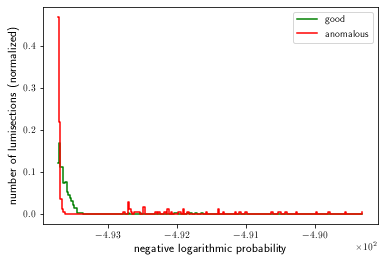

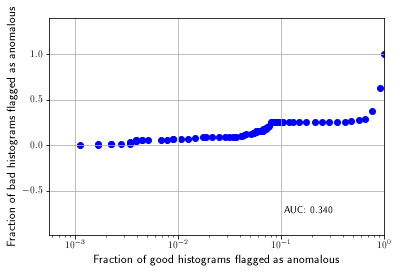

Selected logprob threshold of 493.4648039647308
Accuracy: 0.5660067507478374
Precision: 0.6737516958846532
Recall: 0.25595238095238093
F-Measure: 0.29219033731042293


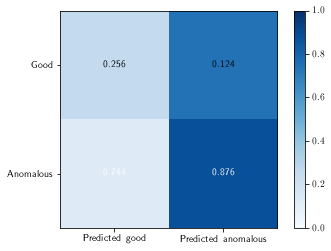

In [30]:
logprob_threshold = evaluate_autoencoders_combined(logprob_good, logprob_bad, fmBiasFactor, wpBiasFactor)